In [10]:
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd


In [11]:
class Gaussian:

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.distr = tfp.distributions.MultivariateNormalTriL(self.mu, tf.linalg.cholesky(self.sigma))

    def pdf(self, x):
        return self.distr.prob(x)

    def cdf(self, x):
        return self.distr.cdf(x)

    def sample(self, n):
        return self.distr.sample(n)

In [12]:
np.random.seed(2)

nsamples = 2000

mu1 = [3, 3]
sigma1 = np.array([[1, 0.5], [0.5, 1]])
f1 = Gaussian(mu1, sigma1)
w1 = 0.35
n1 = int(nsamples * w1)
cluster1 = f1.sample(n1)


mu2 = [5, 2] 
sigma2 = np.array([[0.4, -0.2], [-0.2, 0.2]])
f2 = Gaussian(mu2,  sigma2)
w2 = 0.15
n2 = int(nsamples * w2)
cluster2 = f2.sample(n2)


mu3 = [9, 4]
sigma3 = np.array([[1.0, 0.0], [0.0, 1.0]])
f3 = Gaussian(mu3, sigma3)
w3 = 0.3
n3 = int(nsamples * w3)
cluster3 = f3.sample(n3)

mu4 = [8, 6]
sigma4 = np.array([[0.5, 0], [0, 0.5]])
f4 = Gaussian(mu4, sigma4)
w4 = 0.2
n4 = int(nsamples * w4)
cluster4 = f4.sample(n4)


In [13]:
data = np.concatenate([cluster1, cluster2, cluster3, cluster4])
c = np.concatenate([np.repeat(1,n1), np.repeat(2,n2), np.repeat(3,n3), np.repeat(4,n4)])

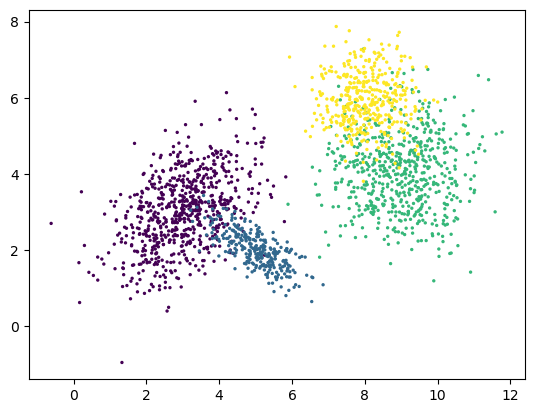

In [14]:
fig = plt.figure()
plt.scatter(data[:,0], data[:,1], c=c, s = 2, marker='o')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_19172\3404062973.py:17: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


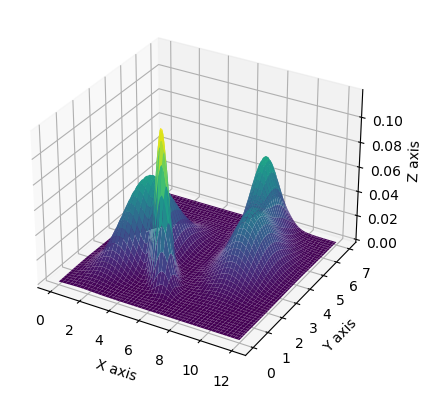

In [15]:
x = np.linspace(0, 12, 100)
y = np.linspace(0, 7, 100)

X, Y = np.meshgrid(x, y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z1 = f1.pdf(pos)
Z2 = f2.pdf(pos)
Z3 = f3.pdf(pos)
Z4 = f4.pdf(pos)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, w1 * Z1 + w2 * Z2 + w3 * Z3 + w4 * Z4,cmap='viridis',linewidth=0)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.show()

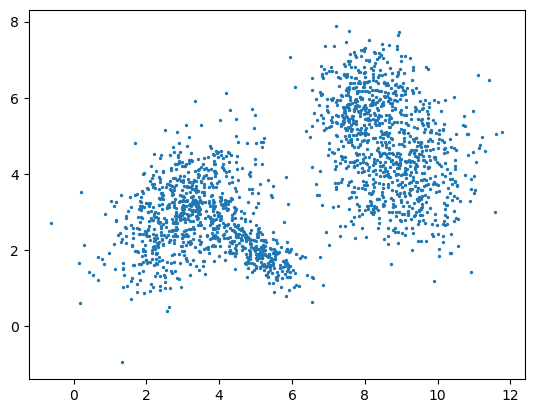

In [16]:
fig = plt.figure()
plt.scatter(data[:,0],data[:,1], s = 2)
plt.show()

In [17]:
def Gibbs_Sampler(data, n_clus, niter, burnin):
    p = data.shape[1]

    alpha = np.ones(n_clus) 
    weights = np.ones(n_clus) / n_clus
    cluster_allocs = tfp.distributions.Categorical(probs = weights).sample(len(data))
    
    cluster_allocs_out = []
    mu_out = []
    sigma_out = []
    weights_out = []

    b0 = np.median(data, axis=0)
    B0 = np.diag((np.max(data, axis=0) - np.min(data, axis=0)) ** 2)
    B0_inv = np.linalg.inv(B0)
    mu0 = tfp.distributions.MultivariateNormalTriL(b0, tf.linalg.cholesky(B0)).sample(n_clus).numpy()

    c0 = 2.5 + 0.5 * (p - 1) 
    phi = 1
    C0 = phi * np.cov(data.T)
    sigma0_inv = tfp.distributions.WishartTriL(c0, tf.linalg.cholesky(np.linalg.inv(C0))).sample(n_clus).numpy()

    cluster_allocs_out.append(cluster_allocs)
    mu_out.append(mu0)
    sigma_out.append(sigma0_inv)
    weights_out.append(weights)

    for i in range(niter):
        print("\rIter {0} / {1}".format(i+1, niter), flush=True, end=" ")

        n_in_clus = np.sum(cluster_allocs == np.arange(n_clus)[:, np.newaxis], axis=1)
        weights = tfp.distributions.Dirichlet(alpha+n_in_clus).sample().numpy()

        mu_iter = []
        sigma_iter = []

        # one step Gibbs
        for j in range(n_clus):
            clusdata = data[cluster_allocs == j, :]
           
            if len(clusdata) == 0:
                clusmean = np.repeat(0, p)
            else:
                clusmean = np.mean(clusdata, axis = 0)

            c_clus = c0 + 0.5 * len(clusdata)
            C_clus = C0 + 0.5 * np.dot((clusdata -  mu_out[-1][j]).T, (clusdata -  mu_out[-1][j])) 
            sigma_clus_inv = tfp.distributions.WishartTriL(c_clus, tf.linalg.cholesky(np.linalg.inv(C_clus))).sample().numpy()

            B_clus = np.linalg.inv(B0_inv + len(clusdata) * sigma_clus_inv)
            b_clus = np.matmul(B_clus, np.matmul(B0_inv, b0) + len(clusdata) * np.matmul(sigma_clus_inv, clusmean))
            mu_clus = tfp.distributions.MultivariateNormalTriL(b_clus,tf.linalg.cholesky(B_clus)).sample().numpy()
    
            sigma_iter.append(sigma_clus_inv)
            mu_iter.append(mu_clus)

        logprobs = tfp.distributions.MultivariateNormalTriL(mu_iter, tf.linalg.cholesky(sigma_iter)).log_prob(data[:, np.newaxis])
        probs = np.exp(np.log(weights) + logprobs)
        probs /= np.sum(probs, axis=1)[:, np.newaxis]

        cluster_allocs = tfp.distributions.Categorical(probs=probs).sample()
        
        if (niter > burnin):
            weights_out.append(weights)
            sigma_out.append(sigma_iter)
            mu_out.append(mu_iter)
            cluster_allocs_out.append(cluster_allocs)

    return cluster_allocs_out, mu_out, sigma_out, weights_out

In [18]:
n_clus = 4
niter = 1000
burnin = -1
z, mu, tau, w = Gibbs_Sampler(data, n_clus, niter, burnin)

Iter 3 / 1000 

C:\Users\andre\AppData\Local\Temp\ipykernel_19172\103613558.py:59: RuntimeWarning: invalid value encountered in true_divide
  probs /= np.sum(probs, axis=1)[:, np.newaxis]


Iter 46 / 1000 

KeyboardInterrupt: 

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(data[:,0], data[:,1], c=c, s = 2, marker='o')
ax2.scatter(data[:,0], data[:,1], c=z[-1], s = 2, marker='o')
plt.show()